In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import xgboost
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

In [2]:
df = pd.read_excel('../../../tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [3]:
df.head()

,text,document,Name,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,class,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
0,2014-10-10 00:00:00,html_files/CMS_2014_0115_0059.pdf,gayani,0.0,0.0,0,Date,0.0,12064,txt,...,3,16,1,0,0,0,0,0,72,NaN
1,Centers for Medicare & Medicaid Services,html_files/CMS_2014_0115_0059.pdf,gayani,0.0,0.0,0,Address,0.0,12065,txt,...,6,40,1,0,0,0,0,0,72,27.0
2,Department of Health and Human Services,html_files/CMS_2014_0115_0059.pdf,gayani,0.0,0.0,0,NaN,0.0,12066,txt,...,6,39,1,0,0,0,0,0,72,13.0
3,Attention: CMS-9968-P,html_files/CMS_2014_0115_0059.pdf,gayani,0.0,0.0,0,NaN,0.0,12067,txt,...,2,21,1,0,0,0,0,0,72,14.0
4,P.O. Box 8013,html_files/CMS_2014_0115_0059.pdf,gayani,0.0,0.0,0,NaN,0.0,12068,txt,...,3,13,1,0,0,0,1,0,72,13.0


In [4]:
df.isna().sum() # comment and LS are missing 

text                         0
document                     0
Name                     31603
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  40782
Class                    34400
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Period                 0
Left_Px 

In [5]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))

#### Drop rows which are not labelled

In [6]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [7]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [8]:
num_docs_done / num_docs

0.3025210084033613

#### Number of Tags Completed: By team member

In [9]:
df.groupby('Name').count()['text'].rename('Count').sort_values()

Name
pranjal    1287
Minsu      1860
Liliana    1885
gayani     2478
Name: Count, dtype: int64

#### Clean px and convert to right data type for columns: fontsize, left and top

In [10]:
df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Separate Target and Features and drop unnecessary columns: Text, Document, Comment and Target

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7510 entries, 0 to 41909
Data columns (total 34 columns):
text                     7510 non-null object
document                 7510 non-null object
Name                     7510 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  1128 non-null object
Class                    7510 non-null float64
df_idx                   7510 non-null int64
class                    7510 non-null object
style                    7510 non-null object
id                       7510 non-null object
font-size                7510 non-null int64
vertical-align           7510 non-null object
color                    7510 non-null object
font-family              7510 non-null object
font-weight              7510 non-null object
font-style               7510 non-null object
position                 7510 non-null object
left               

In [12]:
X = df.drop(['text', 'document', 'Name', 'Section_Id_Document', 
             'Section_ID', 'Paragraph', 'Comment', 'df_idx' , 
             'page', 'Class'], axis = 1)
y = df['Class']

#### Check out imbalance
* There is a lot of imbalance here guys, funnily I got the number right haha it is about 95% 

In [13]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.86%


In [14]:
X.shape

(7510, 24)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7510 entries, 0 to 41909
Data columns (total 24 columns):
class                    7510 non-null object
style                    7510 non-null object
id                       7510 non-null object
font-size                7510 non-null int64
vertical-align           7510 non-null object
color                    7510 non-null object
font-family              7510 non-null object
font-weight              7510 non-null object
font-style               7510 non-null object
position                 7510 non-null object
left                     7510 non-null int64
top                      7510 non-null int64
document_id              7510 non-null int64
line-height              0 non-null float64
Num_Words                7510 non-null int64
String_Length            7510 non-null int64
Leading_Char_Upper       7510 non-null int64
Leading_Numeral          7510 non-null int64
Ends_In_Period           7510 non-null int64
Leading_Number_Period    7510

#### Remove all categorical features for simplicity

In [16]:
X = X.select_dtypes(exclude="object")

#### Fill in missing columns (after inspection) with 0

In [17]:
X.isna().sum() # LS are missing: We will impute after Train Test split to prevent leakage

font-size                   0
left                        0
top                         0
document_id                 0
line-height              7510
Num_Words                   0
String_Length               0
Leading_Char_Upper          0
Leading_Numeral             0
Ends_In_Period              0
Leading_Number_Period       0
Leading_Char_Period         0
Roman_Period                0
Left_Px                     0
LS                        210
dtype: int64

In [18]:
X['LS'] = X['LS'].fillna(0)
X['line-height'] = X['line-height'].fillna(0)

In [19]:
X.isna().sum() # LS are missing: We will impute after Train Test split to prevent leakage

font-size                0
left                     0
top                      0
document_id              0
line-height              0
Num_Words                0
String_Length            0
Leading_Char_Upper       0
Leading_Numeral          0
Ends_In_Period           0
Leading_Number_Period    0
Leading_Char_Period      0
Roman_Period             0
Left_Px                  0
LS                       0
dtype: int64

#### Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 9834) 

#### DO NOT NEED TO DO THIS: Impute Train and Test: We will impute with LS column in both Test and Train with the Median of Train since these are discrete values

In [21]:
# ct = ColumnTransformer([("norm1", SimpleImputer(strategy='median'), ['LS'])])

In [22]:
# ct.fit(X_train) # Fit on X_train only

In [23]:
# X_train['LS'] = ct.transform(X_train) 
# X_test['LS'] = ct.transform(X_test) 

### Logistic Regression

#### Look at cross-validated performance

In [24]:
lr_scores = cross_val_score(LogisticRegression(solver = 'lbfgs'), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.

In [25]:
lr_mean_score

0.9030740391322233

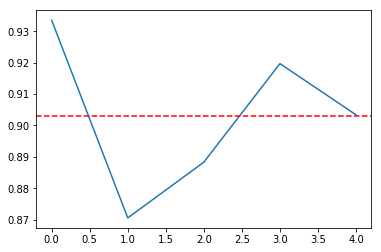

In [26]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [27]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=4896,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [28]:
y_pred = lr.predict(X_test)

#### Model Performance

In [29]:
def metrics(y_test, y_pred):
    print("Score on Test set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

In [30]:
metrics(y_test, y_pred)

Score on Test set
Accuracy score: 0.79
F1 score: 0.09
ROC AUC score: 0.73


In [31]:
def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])

In [32]:
confusion_metrics(y_test, y_pred)

True Negatives: 1468
False Negatives: 10
True Positives: 20
False Positives: 380


#### Look at the Important Features

In [33]:
def feature_importances(coefs):
    n_features =  X_train.shape[1]
    coefs_lr = coefs
    plt.barh(range(n_features), coefs_lr, align='center') 
    plt.yticks(np.arange(n_features), list(X_train.columns.values)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

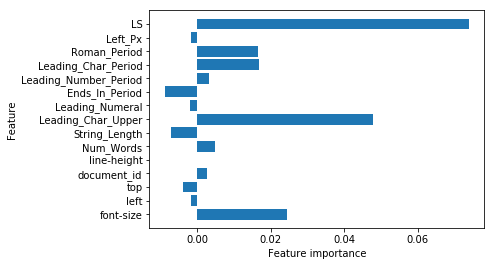

In [34]:
feature_importances(lr.coef_[0])

### Changing Thresholds for Evaluation

In [35]:
y_pred = lr.predict_proba(X_test)[:, 1] > .5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      1848
         1.0       0.05      0.67      0.09        30

   micro avg       0.79      0.79      0.79      1878
   macro avg       0.52      0.73      0.49      1878
weighted avg       0.98      0.79      0.87      1878



In [36]:
confusion_metrics(y_test, y_pred)


True Negatives: 1468
False Negatives: 10
True Positives: 20
False Positives: 380


### Random Forest

In [37]:
rf = RandomForestClassifier() 
rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
y_pred = rf.predict(X_test)

#### Model Performance

In [39]:
metrics(y_test, y_pred)

Score on Test set
Accuracy score: 0.99
F1 score: 0.52
ROC AUC score: 0.70


In [40]:
confusion_metrics(y_test, y_pred)

True Negatives: 1844
False Negatives: 18
True Positives: 12
False Positives: 4


#### Look at the Important Features

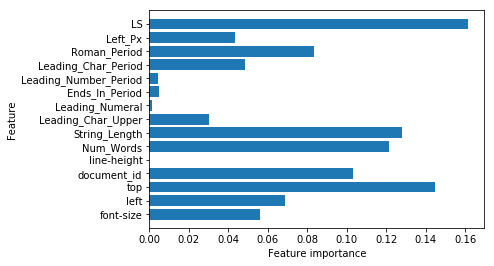

In [41]:
feature_importances(rf.feature_importances_)

### Changing Thresholds

In [42]:
y_pred = rf.predict_proba(X_test)[:, 1] > .5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1848
         1.0       0.75      0.40      0.52        30

   micro avg       0.99      0.99      0.99      1878
   macro avg       0.87      0.70      0.76      1878
weighted avg       0.99      0.99      0.99      1878



### Caliberation Curve for Random Forest: This is still not complete so SKIP this part

In [43]:
probs = rf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(prob_true)
print(prob_pred)

[0.00651466 0.27777778 0.44444444 1.         1.        ]
[0.00852334 0.33888889 0.57777778 0.7        0.925     ]


Logistic:
	Brier: 0.013
	Precision: 0.455
	Recall: 0.167
	F1: 0.244



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC:
	Brier: 0.366
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Isotonic:
	Brier: 0.015
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Sigmoid:
	Brier: 0.016
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



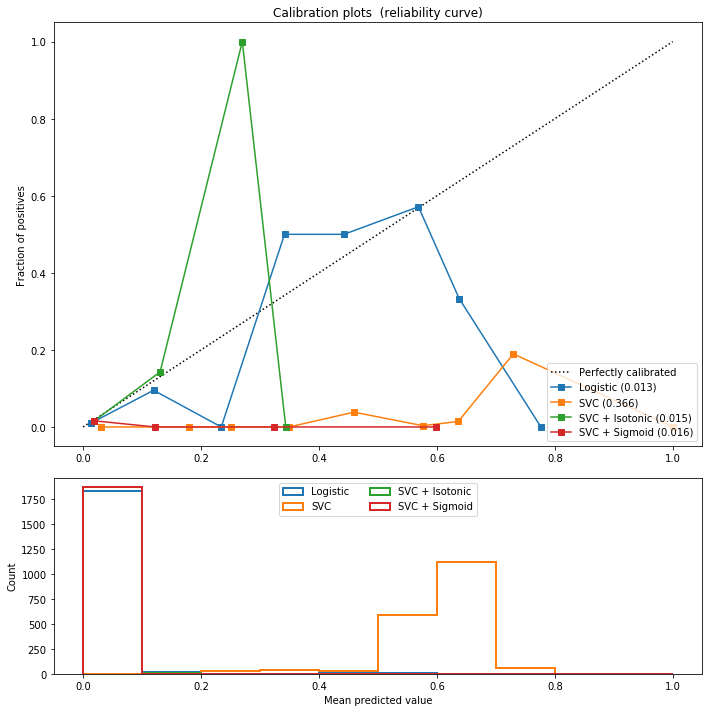

In [44]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()

### Adaboost

In [45]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [46]:
y_pred = ab.predict(X_test)

#### Model Performance

In [47]:
metrics(y_test, y_pred)

Score on Test set
Accuracy score: 0.99
F1 score: 0.32
ROC AUC score: 0.60


In [48]:
confusion_metrics(y_test, y_pred)

True Negatives: 1847
False Negatives: 24
True Positives: 6
False Positives: 1


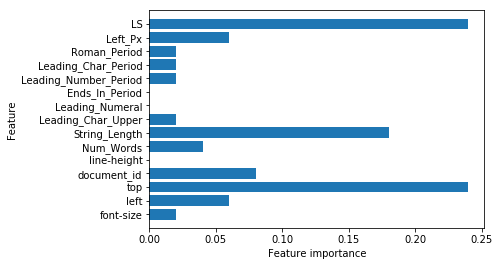

In [49]:
feature_importances(ab.feature_importances_)

#### XGBoost

In [50]:
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [51]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}

In [52]:
model_train = xgboost.train(params, xgb_train, 10, evals = [(xgb_test, "test")])

[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	test-cox-nloglik:3.4012
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[1]	test-cox-nloglik:3.4012
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	test-cox-nloglik:3.4012
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[3]	test-cox-nloglik:3.4012
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	test-cox-nloglik:3.4012
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[5]	test-cox-nloglik:3.40121
[21:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[6]	test-cox-nloglik:3.40121
[21:19:28] src/tre

In [53]:
predictions = np.round(model_train.predict(xgb_test))

In [54]:
accuracy = accuracy_score(y_test, predictions)

In [55]:
X = X_test
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_train)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [56]:
shap_values = shap.TreeExplainer(model_train).shap_values(X_train)

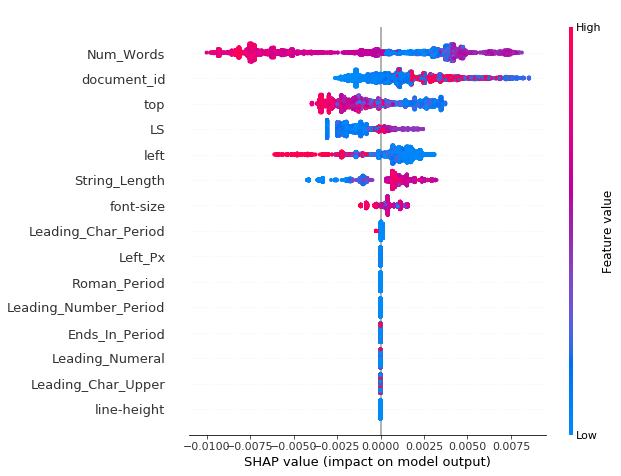

In [57]:
shap.summary_plot(shap_values, X_train)

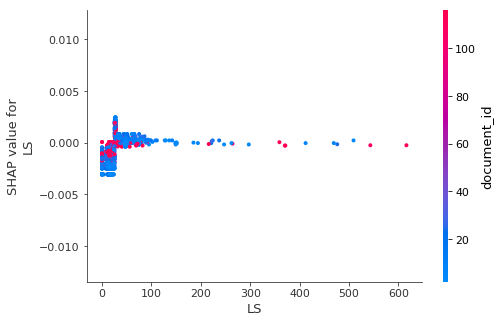

In [58]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train)